In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.callbacks import ModelCheckpoint
from keras import regularizers

Using TensorFlow backend.


In [7]:
# constants
NB_CLASSES = 5
NB_INSTANCES = 5000
IMG_ROWS, IMG_COLS = 28, 28
INPUT_SHAPE = (IMG_ROWS*IMG_COLS,)
BATCH_SIZE = 400
EPOCHS = 200

In [2]:
def load_quickdraw(path, nb_classes, nb_instances):
    # Random dataset load to avoid bias
    images_return = np.load(path + str(0) + '.npy')[np.random.permutation(nb_instances)]
    labels_return = np.zeros(images_return.shape[0])
    for i in range(1, nb_classes):
        images_return = np.concatenate((images_return, np.load(path + str(i) + '.npy')[np.random.permutation(nb_instances)]))
        labels_return = np.concatenate((labels_return, np.ones(images_return.shape[0] - labels_return.shape[0]) * i))
    return images_return.astype('float32') / 255, labels_return

def load_mnist():
    (images_train, labels_train) , (_,_) = mnist.load_data()
    images_train = images_train.astype('float32') / 255.
    images_train = images_train.reshape((len(images_train),28, 28, 1))
    # images_train = images_train.reshape((len(images_train), np.prod(images_train.shape[1:])))
    return images_train, labels_train

def use_checkpoints(is_used):
    if is_used:
        filepath = "checkpoints/cae_model.hdf5"
        return ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    return None

In [4]:
# images_train, labels_train = load_quickdraw('data/quickdraw/', NB_CLASSES, NB_INSTANCES)
images_train, labels_train = load_mnist()

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='sigmoid', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='sigmoid', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Flatten()(x) # 7x7x8

encoded = Dense(2, activation='sigmoid')(x)

x = Dense(392, activation='sigmoid')(encoded)
x = Reshape((7,7,8))(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='sigmoid', padding='same')(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='sigmoid', padding='same')(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

encoder = Model(input_img, encoded)
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

In [5]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 786       
__________

In [ ]:
autoencoder.fit(images_train,
                images_train,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                verbose = 1,
                validation_split=0.33,
                callbacks=[use_checkpoints(True)])

Train on 40199 samples, validate on 19801 samples
Epoch 1/200
40199/40199 [==============================] - 115s 3ms/step - loss: 0.4232 - acc: 0.8066 - val_loss: 0.4024 - val_acc: 0.8096

Epoch 00001: loss improved from inf to 0.42317, saving model to checkpoints/cae_model.hdf5
Epoch 2/200
40199/40199 [==============================] - 113s 3ms/step - loss: 0.3969 - acc: 0.8084 - val_loss: 0.3819 - val_acc: 0.8096

Epoch 00002: loss improved from 0.42317 to 0.39688, saving model to checkpoints/cae_model.hdf5
Epoch 3/200
40199/40199 [==============================] - 107s 3ms/step - loss: 0.3647 - acc: 0.8084 - val_loss: 0.3407 - val_acc: 0.8096

Epoch 00003: loss improved from 0.39688 to 0.36468, saving model to checkpoints/cae_model.hdf5
Epoch 4/200
40199/40199 [==============================] - 112s 3ms/step - loss: 0.3349 - acc: 0.8084 - val_loss: 0.3102 - val_acc: 0.8096

Epoch 00004: loss improved from 0.36468 to 0.33488, saving model to checkpoints/cae_model.hdf5
Epoch 5/200
40

In [93]:
n1 = 2000
images_plot = images_train[n1:n1+10]
encoded_imgs = encoder.predict(images_plot)
autoencoded_imgs = autoencoder.predict(images_plot)

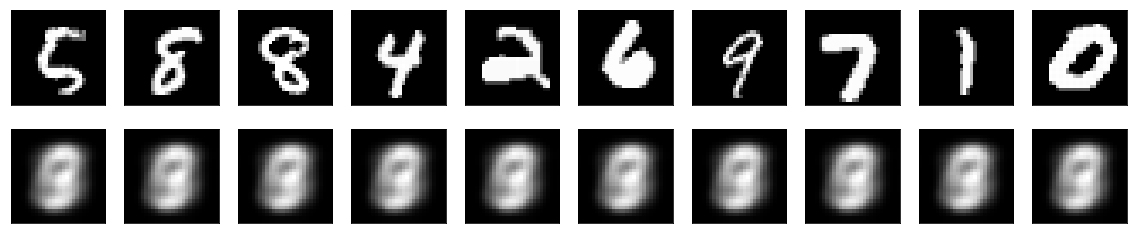

In [94]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images_plot[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(autoencoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

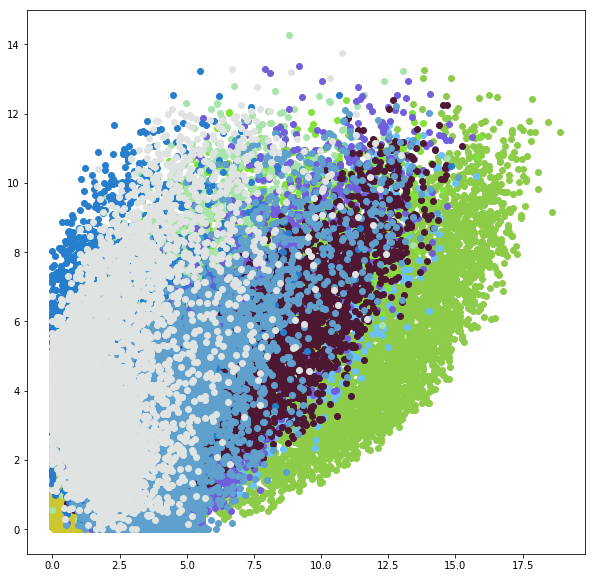

In [83]:
encoded_imgs = encoder.predict(images_train)
x = encoded_imgs[:,0]
y = encoded_imgs[:,1]

colors = np.random.rand(10,3)
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.plot(x[labels_train == i], y[labels_train == i], 'o', color=colors[i]);
plt.show()

In [24]:
images_train[:10].shape

(10, 784)